In [4]:
from typing import Optional
import chipwhisperer as cw
from Crypto.Cipher import AES
from tqdm.notebook import tnrange
import os
import pyvisa as visa
import time
import numpy as np


# Configure the FPGA target
def configure_target():
    bitstreamfile = "hardware/victims/firmware/cw305_aes/cw305_top15.bit"
    target = cw.target(None, cw.targets.CW305, force=True, fpga_id='100t')
    target.vccint_set(1.0)
    target.pll.pll_enable_set(True)
    target.pll.pll_outenable_set(False, 0)
    target.pll.pll_outenable_set(True, 1)
    target.pll.pll_outenable_set(False, 2)
    target.pll.pll_outfreq_set(10E6, 1)

    target.clkusbautooff = True
    target.clksleeptime = 1

    return target


target = configure_target()# Initialize the key and plaintext generator

In [5]:
import pyvisa
rm = visa.ResourceManager()
scope = rm.open_resource('USB0::0x1AB1::0x0515::MS5A221000657::INSTR')

In [8]:
import numpy as np
ktp = cw.ktp.Basic()

# Lists to store keys and plaintexts
textin = []
keys = []
N = 10000#number of traces
waves_traces = []
cipher_traces = []

# Initialize cipher to verify DUT result
key, text = ktp.next()
cipher = AES.new(bytes(key), AES.MODE_ECB)

project = cw.create_project("side_channel_project30.cwp", overwrite=True)
import binascii


#provide key and plaintext for the encryption 
key = binascii.unhexlify('2b7e151628aed2a6abf7158809cf4f3c')
# Capture traces
for i in tnrange(N, desc='Capturing traces'):
    # Generate next key and plaintext pair
    var, text = ktp.next()
    #text = bytearray(text)
    textin.append(text)
    keys.append(key)
    
    
    # ------------------- ARM OSCILLOSCOPE -------------------
    #oscope.write(":SINGLE")  # Set oscilloscope to single-shot mode, waiting for trigger
    
    # Encrypt using the CW305 target
    raw_waveform, gen_ciphertext = cw.encrypt_ascii(scope,target, text, key)
    # Plot the trace
    # Verify the encryption result against the expected value
    expected_ciphertext = cipher.encrypt(bytes(text))
    assert list(gen_ciphertext) == list(expected_ciphertext), \
        f"Incorrect encryption result! Got {ciphertext} Exp {list(expected_ciphertext)}"
    waves_traces.append(raw_waveform)
    cipher_traces.append(gen_ciphertext)

Capturing traces:   0%|          | 0/10000 [00:00<?, ?it/s]

In [2]:
import matplotlib.pyplot as plt

# Select the trace index you want to plot (e.g., the first trace)
for i in range(10):
    trace = waves_traces[i]

    # Plot the trace
    plt.figure(figsize=(12, 6))
    plt.plot(trace, label=f'Trace {i}')
    plt.title(f'Power Trace {i}')
    plt.xlabel('Sample Points')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    plt.show()

NameError: name 'waves_traces' is not defined

In [9]:
import numpy as np
import scipy.io

# Convert your list of voltage traces (each of length 1000) to a 2D array
datapoints = np.array(waves_traces)  # Should be shape (1000, 1000)
plaintexts_SCA = np.array(cipher_traces)  # If you're using the ciphertexts as "plaintexts_SCA"

scipy.io.savemat("attack_data_all_ascii.mat", {"datapoints": datapoints, "plaintexts_SCA": plaintexts_SCA})
print("MATLAB file 'attack_data_all_ascii.mat' created successfully!")

MATLAB file 'attack_data_all_ascii.mat' created successfully!


In [11]:
# Option 1: Using NumPy's savetxt (assuming each trace is a 1D array of equal length)
np_traces = np.array(traces)
np.savetxt("traces.csv", np_traces, delimiter=",")
print("Traces saved to traces.csv")

# Optionally, save keys and plaintexts as separate CSV files:
np.savetxt("keys.csv", np.array(keys), fmt='%s', delimiter=",")
np.savetxt("plaintexts.csv", np.array(textin), fmt='%s', delimiter=",")
print("Keys and plaintexts saved to keys.csv and plaintexts.csv respectively.")

Traces saved to traces.csv
Keys and plaintexts saved to keys.csv and plaintexts.csv respectively.


In [9]:
import numpy as np
import scipy.io

# Assuming that your capture code has already filled these variables:
# 'traces' is a list of voltage_trace arrays (each trace in mV)
# 'textin' is a list of plaintexts corresponding to each trace

# Convert the lists to NumPy arrays.
datapoints = np.array(traces)          # Each row is one voltage trace
plaintexts_SCA = np.array(textin)        # Each row contains the corresponding plaintext

# Save the data to a MATLAB .mat file.
scipy.io.savemat("attack_data_all_ascii.mat", {"datapoints": datapoints, "plaintexts_SCA": plaintexts_SCA})

print("MATLAB file 'attack_data_all_ascii.mat' created successfully!")


MATLAB file 'attack_data_all_ascii.mat' created successfully!


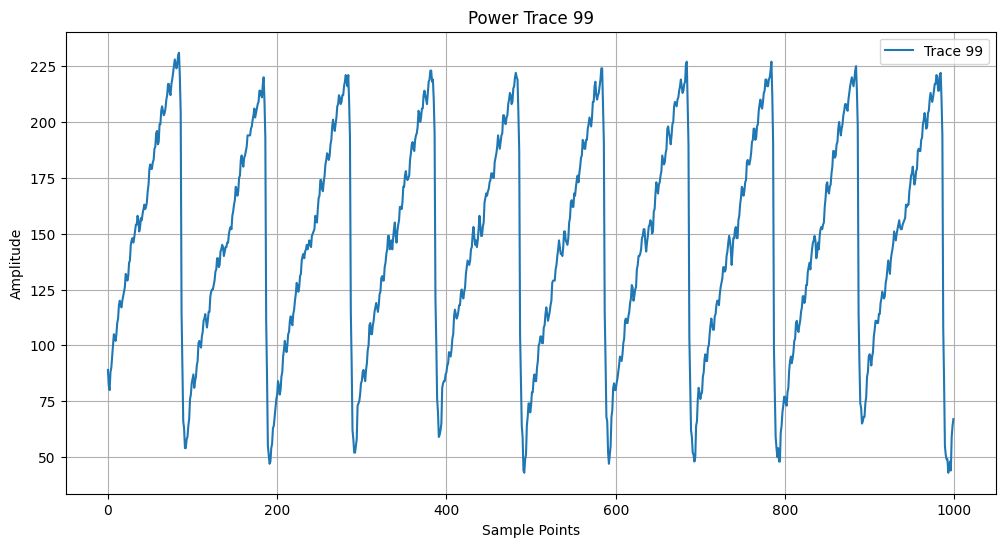

In [8]:
import chipwhisperer as cw
import matplotlib.pyplot as plt

# Load the ChipWhisperer project
project = cw.open_project("side_channel_project30.cwp")

# Select the trace index you want to plot (e.g., the first trace)
trace_index = 99
trace = project.traces[trace_index]

# Plot the trace
plt.figure(figsize=(12, 6))
plt.plot(trace.wave, label=f'Trace {trace_index}')
plt.title(f'Power Trace {trace_index}')
plt.xlabel('Sample Points')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
import chipwhisperer as cw
import numpy as np

# Open the existing project
project = cw.open_project("side_channel_project30.cwp")

# Arrays to store extracted traces and plaintexts
extracted_traces = []
extracted_textin = []

# Loop through all stored traces in the project
for trace in project.traces:
    extracted_traces.append(trace.wave)  # Extract the power trace
    extracted_textin.append(trace.textin)  # Extract the plaintext

# Print extracted traces and plaintexts
print("Extracted Traces:\n", extracted_traces[:5])  # Print first 5 traces for verification
print("\nExtracted Plaintexts:\n", extracted_textin[:5])  # Print first 5 plaintexts for verification

# Optionally, check total counts
print("\nTotal Number of Extracted Traces:", len(extracted_traces))
print("Total Number of Extracted Plaintexts:", len(extracted_textin))


Extracted Traces:
 [memmap([ 69.,  73.,  72.,  78.,  80.,  82.,  80.,  83.,  85.,  93.,  95.,
        101., 101.,  99.,  98., 101., 102., 108., 111., 114., 112., 110.,
        113., 120., 120., 125., 127., 125., 124., 129., 131., 135., 137.,
        142., 141., 135., 135., 134., 137., 144., 145., 144., 144., 142.,
        144., 151., 153., 159., 161., 159., 159., 162., 163., 167., 170.,
        174., 173., 174., 176., 178., 178., 185., 186., 183., 183., 185.,
        186., 189., 191., 196., 195., 192., 193., 197., 198., 202., 205.,
        207., 203., 201., 205., 206., 206., 213., 214., 198., 183., 106.,
         82.,  52.,  49.,  40.,  38.,  33.,  37.,  49.,  51.,  61.,  67.,
         64.,  64.,  66.,  67.,  70.,  72.,  77.,  78.,  76.,  77.,  85.,
         86.,  91.,  94.,  96.,  92.,  90.,  92.,  95.,  97., 103., 103.,
        100.,  99., 103., 105., 110., 112., 116., 115., 112., 115., 122.,
        124., 129., 129., 126., 123., 118., 124., 130., 129., 131., 131.,
        125., 125.

In [11]:
import chipwhisperer as cw
import numpy as np
import scipy.io

# Load the ChipWhisperer project file
project = cw.open_project("side_channel_project30.cwp")

# Extract traces (waveforms)
datapoints = np.array([trace.wave for trace in project.traces])

# Extract plaintexts
plaintexts_SCA = np.array([trace.textin for trace in project.traces])

# Save as attack_data_all_2.mat
scipy.io.savemat("attack_data_all_3.mat", {"datapoints": datapoints, "plaintexts_SCA": plaintexts_SCA})

print("MATLAB file 'attack_data_all_3.mat' created successfully!")


MATLAB file 'attack_data_all_3.mat' created successfully!


In [16]:
import chipwhisperer as cw
import chipwhisperer.analyzer as cwa
project_file = "side_channel_project20"
project = cw.open_project(project_file)
attack = cwa.cpa(project, cwa.leakage_models.mix_columns_output)
#attack = cwa.cpa(project, cwa.leakage_models.last_round_state_diff)
cb = cwa.get_jupyter_callback(attack)

In [17]:
attack_results = attack.run(cb)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
PGE=,74,129,234,233,30,81,45,89,153,8,234,119,122,48,176,195
0,F80.042,FF0.011,FF0.000,FF0.011,880.043,FF0.031,FF0.011,FF0.021,660.043,FF0.000,FF0.010,FF0.011,010.043,FF0.000,FF0.000,FF0.000
1,2C0.042,FE0.011,FE0.000,FE0.011,570.042,FE0.031,FE0.011,FE0.021,540.042,FE0.000,FE0.010,FE0.011,5A0.043,FE0.000,FE0.000,FE0.000
2,420.032,FD0.011,FD0.000,FD0.011,3F0.033,FD0.031,FD0.011,FD0.021,CC0.032,FD0.000,FD0.010,FD0.011,F80.032,FD0.000,FD0.000,FD0.000
3,8F0.032,FC0.011,FC0.000,FC0.011,2F0.032,FC0.031,FC0.011,FC0.021,DC0.032,FC0.000,FC0.010,FC0.011,930.032,FC0.000,FC0.000,FC0.000
4,9C0.032,FB0.011,FB0.000,FB0.011,240.032,FB0.031,FB0.011,FB0.021,300.032,FB0.000,FB0.010,FB0.011,480.032,FB0.000,FB0.000,FB0.000


In [ ]:
import pickle
pickle_file = project_file + ".results.pickle"
pickle.dump(attack_results, open(pickle_file, "wb"))

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming attack_results contains the necessary data
# For example, the attack results might contain correlation data (PGE table)
# We'll assume the data is available in attack_results.correlation_data, modify according to the actual structure

# Extract the correlation data or PGE table (modify this as necessary)
correlation_data = attack_results.correlation_data  # Or whatever structure your results have
# You may need to print the structure of attack_results to understand where the PGE table is stored

# Now we can plot the results (this will depend on how the data is structured)
# Assuming it’s a 2D array or matrix of correlations

# Example of plotting the PGE table or correlation graph
plt.figure(figsize=(10, 6))
plt.imshow(correlation_data, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Correlation Heatmap (PGE Table)")
plt.xlabel("Key Guess Index")
plt.ylabel("Trace Index")
plt.show()


NameError: name 'attack_results' is not defined

In [ ]:
from chipwhisperer.analyzer.attacks.models.aes.key_schedule import key_schedule_rounds
recv_lastroundkey = [kguess[0][0] for kguess in attack_results.find_maximums()]
recv_key = key_schedule_rounds(recv_lastroundkey, 10, 0)
for subkey in recv_key:
    print(hex(subkey))

In [5]:
key = list(key)
assert (key == recv_key), "Failed to recover encryption key\nGot:      {}\nExpected: {}".format(recv_key, key)

NameError: name 'recv_key' is not defined

In [2]:
import binascii

#rm = visa.ResourceManager()
#oscope = rm.open_resource('USB0::10893::6000::MY58491988::INSTR')


################################################## Encryption ###################################3
#provide key and plaintext for the encryption 
key = binascii.unhexlify('2b7e151628aed2a6abf7158809cf4f3c')
text = binascii.unhexlify('6857c3d7119a77b9ac3df060b14d5686')

print("the text is", text)
print("the key is ", key)

#oscope.write(":RUN")  # Start acquisition (like pressing "Run")

# calculate the ciphertext using generated bitstream 
ciphertext = cw.encrypt(target, text, key)
print("Actual ciphertext is", ciphertext.hex())


    # ------------------- AUTOMATICALLY PRESS "STOP" -------------------
#oscope.write(":STOP")  # Like pressing the "Stop" button manually

cipher = AES.new(bytes(key), AES.MODE_ECB)  # Initialize cipher for verification using AES library from pycryptodome, use ECB mode
expected_ciphertext = cipher.encrypt(bytes(text))    # enccrypt the text using the encrypt function of the cipther object , standard AES



hex_cipherTex = bytearray(expected_ciphertext)
print("Expected cipherText is ",hex_cipherTex.hex())


# Compare correctly
assert ciphertext == bytearray(expected_ciphertext), \
    f"Incorrect encryption result! Got {ciphertext} Exp {bytearray(expected_ciphertext)}"
print('--------------------------------------------------------------------------------')


the text is b'hW\xc3\xd7\x11\x9aw\xb9\xac=\xf0`\xb1MV\x86'
the key is  b'+~\x15\x16(\xae\xd2\xa6\xab\xf7\x15\x88\t\xcfO<'
Actual ciphertext is e8bf68da05686dce47a89b7201ab5bca
Expected cipherText is  e8bf68da05686dce47a89b7201ab5bca
--------------------------------------------------------------------------------


In [6]:
import numpy as np
ktp = cw.ktp.Basic()

# Lists to store keys and plaintexts
textin = []
keys = []
N = 1000# Number of traces
traces = []

# Initialize cipher to verify DUT result
key, text = ktp.next()
cipher = AES.new(bytes(key), AES.MODE_ECB)

project = cw.create_project("side_channel_project30.cwp", overwrite=True)
import binascii
# Capture traces
for i in tnrange(N, desc='Capturing traces'):
    # Generate next key and plaintext pair
    key, text = ktp.next()
    #text = bytearray(text)
    textin.append(text)
    keys.append(key)
    
    
    # ------------------- ARM OSCILLOSCOPE -------------------
    #oscope.write(":SINGLE")  # Set oscilloscope to single-shot mode, waiting for trigger
    
    # Encrypt using the CW305 target
    ret = cw.encrypt(scope,target, text, key)
    if not ret:
        print("Failed capture")
        continue
    # Verify the encryption result against the expected value
    expected_ciphertext = cipher.encrypt(bytes(text))
    assert list(ret) == list(expected_ciphertext), \
        f"Incorrect encryption result! Got {ciphertext} Exp {list(expected_ciphertext)}"
    #traces.append(ret.wave)
    #project.traces.append(ret)

project.save()

Capturing traces:   0%|          | 0/1000 [00:00<?, ?it/s]